In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme,spectral_vector_properties)

from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

# plotly.offline.init_notebook_mode()
# qualitative_cmap, diverging_cmap, light_cmap = initialize_theme()

# import data

In [12]:
pulldate = "250702"
datafolder = Path("../data/processed")
datasets = {
    "lab":{}
}

In [14]:
# lots should be cleaned and preprocessed

for dataset in datasets:

    # load the dataset
    cleaned_input = pd.read_csv(datafolder / f"X_all.csv", index_col=0)
    cleaned_label = pd.read_csv(datafolder / f"y_all.csv", index_col=0)

    datasets[dataset]['cleaned_input'] = cleaned_input
    datasets[dataset]['cleaned_label'] = cleaned_label

    # # convert datetime column from Unix to datetime
    # datasets['full']['cleaned_label']['date_scanned'] = pd.to_datetime(datasets['full']['cleaned_label']['date_scanned'], unit='s')
    # datasets['full']['cleaned_label']['date_scanned'] = datasets['full']['cleaned_label']['date_scanned'].dt.date

    print(f"Dataset: {dataset} has {cleaned_input.shape} spectra and {cleaned_label.shape} label")

Dataset: lab has (467, 191) spectra and (467, 9) label


In [17]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    label_df = datasets[dataset]['cleaned_label']

    param_label_map = {}

    for col in label_df.columns:
        if col != 'set':
            continue

        if label_df[col].dtype == 'float64':
            param_label_map[col] = 'reg'
        elif label_df[col].dtype == 'object':
            param_label_map[col] = 'clf'

    datasets[dataset]["param_label_map"] = param_label_map

Processing lab dataset


In [18]:
for dataset in datasets:
    print(datasets[dataset]['param_label_map'])

{'set': 'clf'}


# filter data

In [19]:
# create a new dict selections to only have deo and nondeo datasets
selections = datasets.copy()

# plotting functions

In [20]:
def plot_spectra_summary(plot_df, 
                        labels, 
                        spec_prep,
                        sample_type,
                        label_order=None, 
                        mean_center=False):
    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5))
    
    unique_labels = labels.iloc[:, 0].unique()
    
    # Custom order if provided
    if label_order is not None:
        # Keep only labels that exist in the data
        unique_labels = [label for label in label_order if label in unique_labels]
        # Add any remaining labels not in the custom order
        remaining = [label for label in unique_labels if label not in label_order]
        unique_labels.extend(remaining)
    else:
        unique_labels = sorted(unique_labels)
    
    colors = plt.cm.tab10(np.arange(len(unique_labels)))
    
    # Calculate overall mean for mean centering
    overall_mean = plot_df.mean()
    
    for i, label in enumerate(unique_labels):
        mask = labels.iloc[:, 0] == label
        spectra_subset = plot_df[mask]
        
        mean_spectrum = spectra_subset.mean()
        std_spectrum = spectra_subset.std()
        wavelengths = spectra_subset.columns.astype(float)
        
        # Original plot (left subplot)
        ax1.plot(wavelengths, mean_spectrum, color=colors[i], 
               linewidth=2, label=f'{label} (mean)')
        ax1.fill_between(wavelengths, 
                       mean_spectrum - std_spectrum,
                       mean_spectrum + std_spectrum,
                       color=colors[i], alpha=0.2,
                       label=f'{label} (mean ±1σ)')
        
        # Mean centered plot (right subplot)
        mean_centered_spectrum = mean_spectrum - overall_mean
        ax2.plot(wavelengths, mean_centered_spectrum, color=colors[i], 
               linewidth=2, 
            #    label=f'{label} (mean)'
               )
        ax2.fill_between(wavelengths, 
                       mean_centered_spectrum - std_spectrum,
                       mean_centered_spectrum + std_spectrum,
                       color=colors[i], alpha=0.2,
                    #    label=f'{label} (mean ±1σ)'
                       )
    
    # Set titles and labels for both subplots
    ax1.set_title('Original Spectra')
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('Intensity')
    ax1.legend(loc = 'lower right')
    
    ax2.set_title('Mean Centered Spectra')
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Intensity (Mean Centered)')
    ax2.legend(loc = 'lower right')

    # add title
    fig.suptitle(
            f'{sample_type} | Spectra: {spec_prep} | Parameter: {labels.columns[0]}', size=15)
    
    plt.tight_layout()

# No Preprocessing

In [21]:
PREPROCESSING = 'No Preprocessing'


Processing lab dataset
(467, 191) (467, 9)
Generating figure for set


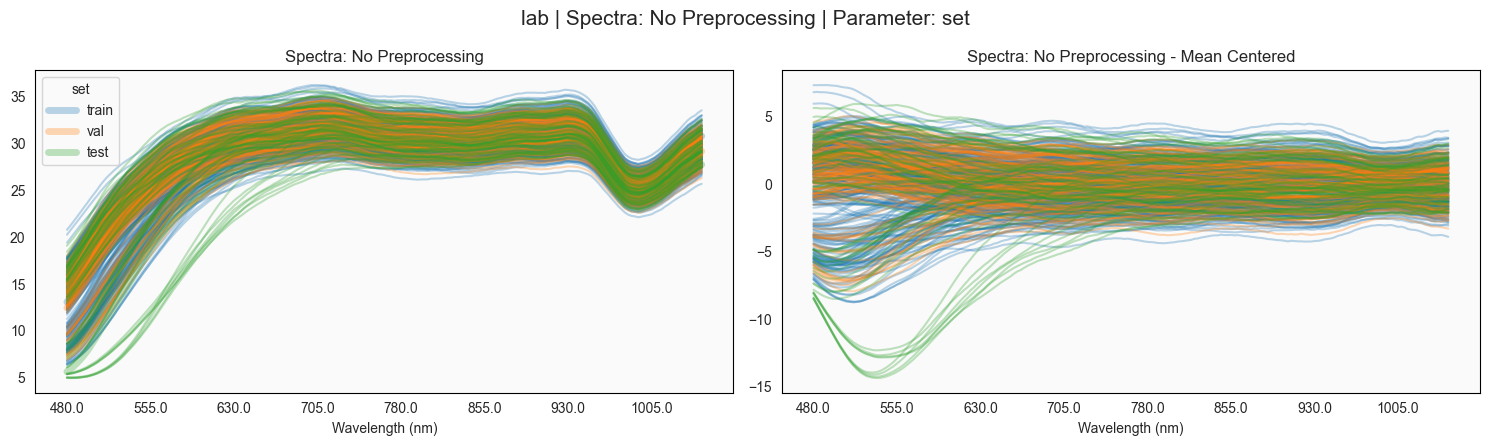

In [22]:
for selection in selections:
    print(f'\nProcessing {selection} dataset')
    output_dir = Path(f"../data/visualisation/{selection}/{PREPROCESSING}")
    output_dir.mkdir(exist_ok=True, parents=True)

    SAMPLE_TYPE = f'{selection}'

    selected_df = selections[selection]['cleaned_input']
    selected_labels = selections[selection]['cleaned_label']
    param_label_map = selections[selection]['param_label_map']
    
    print(selected_df.shape, selected_labels.shape)

    plot_df = selected_df.copy()

    selections[selection]['plot_df'] = plot_df

    for param, label_type in param_label_map.items():
        # # check if png exists
        # if (output_dir / f"{selection}_spectra_{param}.png").exists():
        #     print(f"Skipping {selection} {param}")
        #     continue

        if param == 'set':
            desired_order = ['train', 'val', 'test']
            selected_labels[param] = pd.Categorical(selected_labels[param], categories=desired_order, ordered=True)

        print(f'Generating figure for {param}')
        plot_spectra(plot_df, labels=selected_labels[[param]],
                    label_type=label_type,
                    spec_prep=PREPROCESSING,
                    sample_type=SAMPLE_TYPE,
                    # cmap=cmap
                    )
        
        # plt.savefig(output_dir / f"{selection}_spectra_{param}.png", bbox_inches='tight')
        plt.show()
        plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


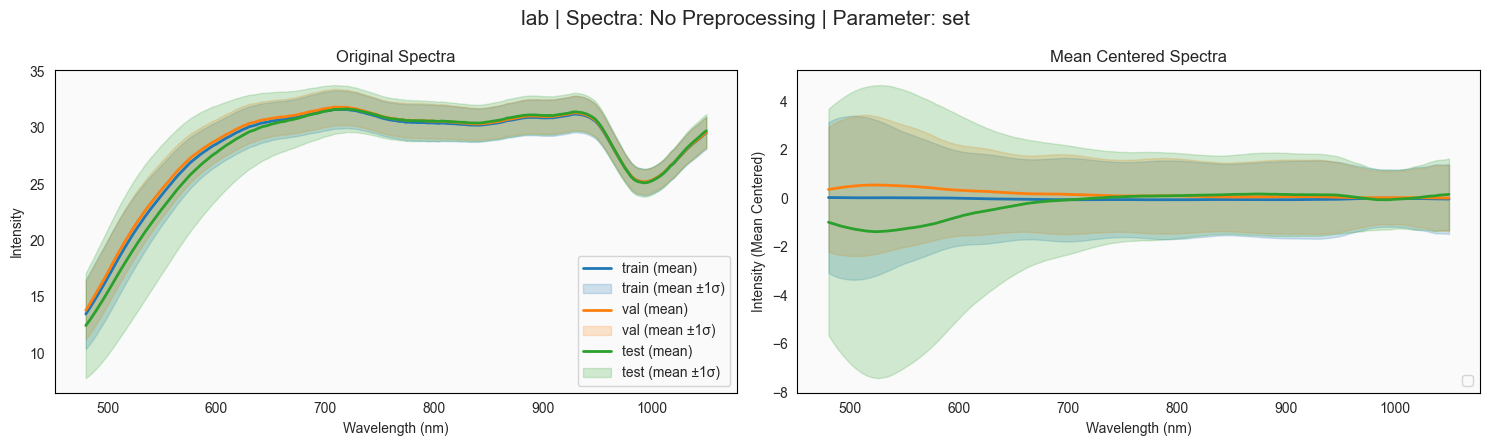

In [23]:
plot_spectra_summary(plot_df, 
                    selected_labels[[param]],
                    spec_prep=PREPROCESSING,
                    sample_type=SAMPLE_TYPE,
                    label_order=['train', 'val','test'], 
                    mean_center=True)

plt.savefig(output_dir / f"{selection}_statsummary_{param}.png", bbox_inches='tight')

In [ ]:
# N_COMP = 0.99
# RANDOM_STATE = 42

# for selection in selections:

#     output_dir = Path(f"../data/visualisation/{selection}/{PREPROCESSING}")
#     output_dir.mkdir(exist_ok=True, parents=True)
    
#     SAMPLE_TYPE = f'{selection}'

#     plot_df = selections[selection]['plot_df']

#     fitted_pc, pc_labels = fit_pca(plot_df, N_COMP, RANDOM_STATE)

#     selections[selection]['fitted_pc'] = fitted_pc
#     selections[selection]['pc_labels'] = pc_labels

#     fig2, ax2 = plot_loadings(plot_df, fitted_pc, pc_labels, 
#                             spec_prep=PREPROCESSING, 
#                             sample_type=SAMPLE_TYPE)
    
#     plt.savefig(output_dir / f"{selection}_pca_loadings.png", bbox_inches='tight')
#     plt.show()
#     plt.close()

#     fig1, ax1 = plot_scree(fitted_pc,
#                         spec_prep=PREPROCESSING, 
#                         sample_type=SAMPLE_TYPE)
#     print(f"""Total Explained Variance: {fitted_pc.explained_variance_ratio_.sum()*100:.3f}% 
#     Number of Components: {len(fitted_pc.explained_variance_ratio_)}""")

#     plt.savefig(output_dir / f"{selection}_scree_plot.png", bbox_inches='tight')
#     plt.show()
#     plt.close()

In [ ]:
# for selection in selections:
#     SAMPLE_TYPE = f'{selection}'
#     print(f'\nProcessing {selection} dataset')
#     output_dir = Path(f"../data/visualisation/{selection}/{PREPROCESSING}")
#     output_dir.mkdir(exist_ok=True, parents=True)
    
#     selected_df = selections[selection]['cleaned_input']
#     selected_labels = selections[selection]['cleaned_label']
#     param_label_map = selections[selection]['param_label_map']
#     plot_df = selections[selection]['plot_df']
#     fitted_pc = selections[selection]['fitted_pc']
#     pc_labels = selections[selection]['pc_labels']

#     print(plot_df.shape, selected_labels.shape)

#     for param in param_label_map.keys():
#         # check if png exists
#         if (output_dir / f"{selection}_pca_{param}.png").exists():
#             print(f"Skipping {selection} {param}")
#             continue

#         print(f'Generating figure for {param}')
#         pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=selected_labels[[param]])
#         sns.pairplot(data=pc_df.reset_index().drop('lot_id', axis=1), hue=param)
#         plt.suptitle(f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING} | Parameter: {param}', y=1.02, size=15)

#         plt.savefig(output_dir / f"{selection}_pca_{param}.png", bbox_inches='tight')
#         # plt.show()
#         plt.close()

In [ ]:
# fig = make_subplots(rows=3, cols= 2, 
#                     subplot_titles=['F Test Spectra', 'F Test PCA', 
#                                     'Mutual Info Spectra', 'Mutual Info PCA',
#                                     'Chi2 Spectra', 'Chi2 PCA'],
#                     specs=[[{'secondary_y': True}, {'secondary_y': True}],
#                            [{'secondary_y': False}, {'secondary_y': False}],
#                            [{'secondary_y': True}, {'secondary_y': True}]],
#                     horizontal_spacing=0.15,
#                     vertical_spacing=0.1)

# title = f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING}'
# colors = px.colors.qualitative.Plotly
# pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=label_df)
# n_comp = fitted_pc.n_components_

# for i, param in enumerate(param_label_map.keys()):
#     try:
#         f_reg_spec = f_classif(plot_df, label_df[param].values.ravel())
#         f_reg_pca = f_classif(pc_df.iloc[:, :n_comp], pc_df[param].values.ravel())
#         mms = MinMaxScaler()
#         scaled_spec = mms.fit_transform(plot_df)
#         scaled_pca = mms.fit_transform(pc_df.iloc[:, :n_comp])
#         mi_spec = mutual_info_classif(scaled_spec, label_df[param].values.ravel())
#         mi_pca = mutual_info_classif(scaled_pca, pc_df[param].values.ravel())
#         chi2_spec = chi2(scaled_spec, label_df[param].values.ravel())
#         chi2_pca = chi2(scaled_pca, pc_df[param].values.ravel())
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=mi_spec, marker_color=colors[i], name=param,
#                        opacity=0.8, showlegend=False),
#                        secondary_y=False,row=2, col=1)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=mi_pca, name=param, marker_color=colors[i],
#                        showlegend=False, opacity=0.8),
#                     secondary_y=False, row=2, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=2)
        
#     except:
#         pass

# # Add figure title
# fig.update_layout(title_text=title, height=1400, width=1400)
# fig.update_xaxes(title_text="Wavelengths (nm)", col=1)
# fig.update_xaxes(title_text="No. of PCs", col=2)

# # Set y-axes titles
# fig.update_yaxes(title_text="F value", secondary_y=False, row=1)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=1)
# fig.update_yaxes(title_text="Mutual Information", secondary_y=False, row=2)
# fig.update_yaxes(title_text="Chi2", secondary_y=False, row=3)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=3)

# fig.show()

# SNV

In [24]:
viz_output_dir = Path(f"../data/visualisation")

In [25]:
# CONFIGS
PREPROCESSING = 'SNV'


Processing lab dataset
(467, 191) (467, 9)
Generating figure for set


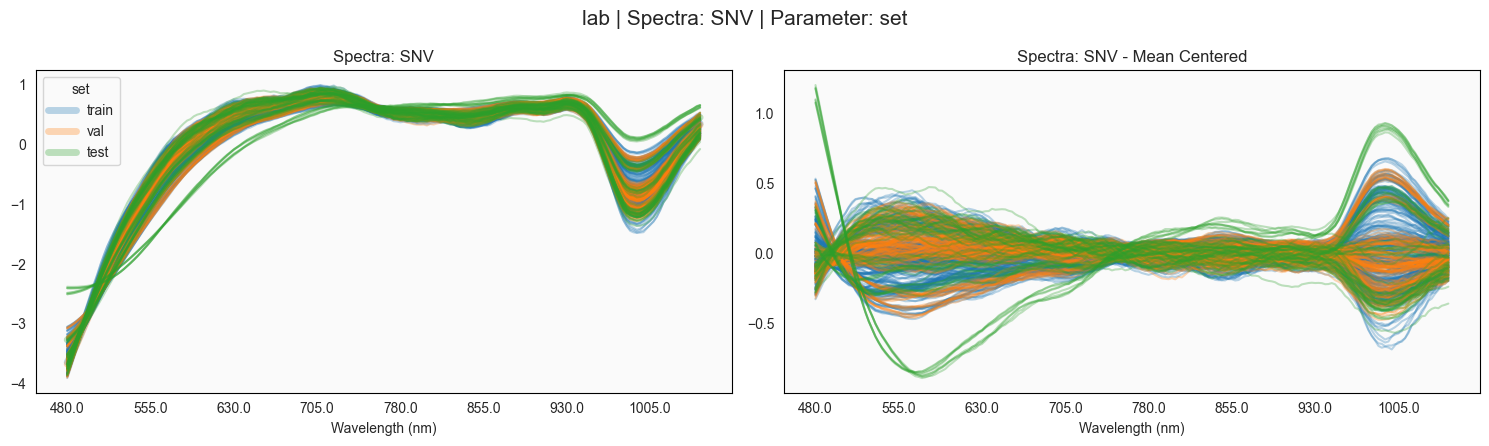

In [26]:
for selection in selections:
    print(f'\nProcessing {selection} dataset')
    output_dir = viz_output_dir/f"{selection}/{PREPROCESSING}"
    output_dir.mkdir(exist_ok=True, parents=True)

    SAMPLE_TYPE = f'{selection}'

    selected_df = selections[selection]['cleaned_input']
    selected_labels = selections[selection]['cleaned_label']
    param_label_map = selections[selection]['param_label_map']
    
    print(selected_df.shape, selected_labels.shape)

    snv_df = pd.DataFrame(SNV().fit_transform(selected_df), columns=selected_df.columns, index=selected_df.index)
    plot_df = snv_df.copy()

    selections[selection]['plot_df'] = plot_df

    for param, label_type in param_label_map.items():
        # # check if png exists
        # if (output_dir / f"{selection}_spectra_{param}.png").exists():
        #     print(f"Skipping {selection} {param}")
        #     continue

        if param == 'set':
            desired_order = ['train', 'val', 'test']
            selected_labels[param] = pd.Categorical(selected_labels[param], categories=desired_order, ordered=True)
        
        print(f'Generating figure for {param}')
        plot_spectra(plot_df, labels=selected_labels[[param]],
                    label_type=label_type,
                    spec_prep=PREPROCESSING,
                    sample_type=SAMPLE_TYPE,
                    # cmap=cmap
                    )
        
        # plt.savefig(output_dir / f"{selection}_spectra_{param}.png", bbox_inches='tight')

        if param =="set":
            plt.show()
        plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


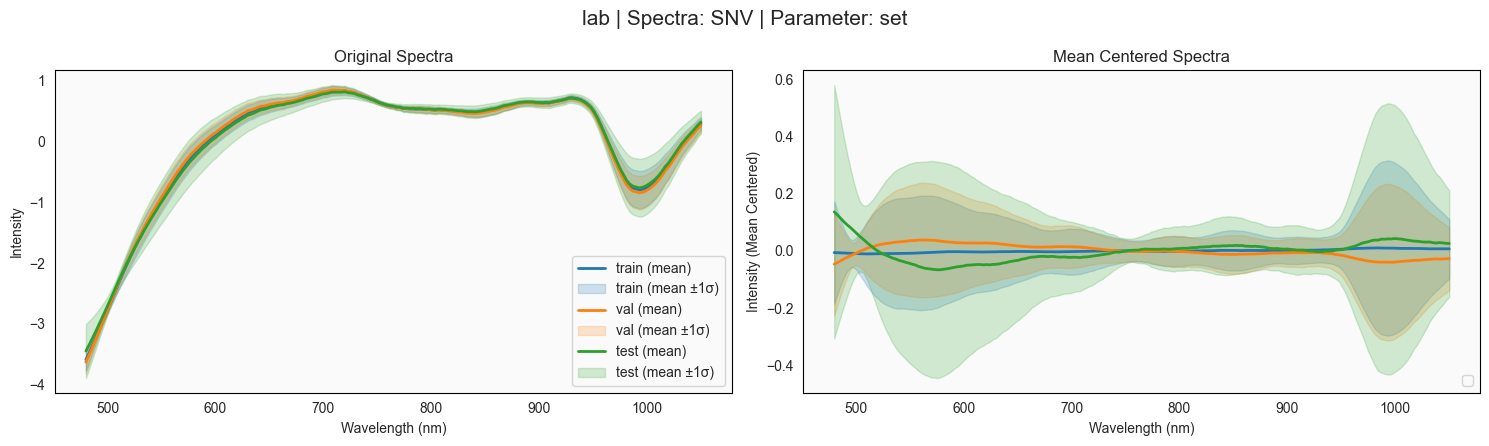

In [27]:
plot_spectra_summary(plot_df, 
                    selected_labels[[param]],
                    spec_prep=PREPROCESSING,
                    sample_type=SAMPLE_TYPE,
                    label_order=['train', 'val','test'], 
                    mean_center=True)

plt.savefig(output_dir / f"{selection}_statsummary_{param}.png", bbox_inches='tight')

In [ ]:
N_COMP = 0.99
RANDOM_STATE = 42

for selection in selections:

    output_dir = viz_output_dir/f"{selection}/{PREPROCESSING}"
    output_dir.mkdir(exist_ok=True, parents=True)
    
    SAMPLE_TYPE = f'{selection}'

    plot_df = selections[selection]['plot_df']

    fitted_pc, pc_labels = fit_pca(plot_df, N_COMP, RANDOM_STATE)

    selections[selection]['fitted_pc'] = fitted_pc
    selections[selection]['pc_labels'] = pc_labels

    fig2, ax2 = plot_loadings(plot_df, fitted_pc, pc_labels, 
                            spec_prep=PREPROCESSING, 
                            sample_type=SAMPLE_TYPE)
    
    plt.savefig(output_dir / f"{selection}_pca_loadings.png", bbox_inches='tight')
    plt.show()
    plt.close()

    fig1, ax1 = plot_scree(fitted_pc,
                        spec_prep=PREPROCESSING, 
                        sample_type=SAMPLE_TYPE)
    print(f"""Total Explained Variance: {fitted_pc.explained_variance_ratio_.sum()*100:.3f}% 
    Number of Components: {len(fitted_pc.explained_variance_ratio_)}""")

    plt.savefig(output_dir / f"{selection}_scree_plot.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
for selection in selections:
    SAMPLE_TYPE = f'{selection}'
    print(f'\nProcessing {selection} dataset')
    output_dir = viz_output_dir/f"{selection}/{PREPROCESSING}"
    output_dir.mkdir(exist_ok=True, parents=True)
    
    selected_df = selections[selection]['cleaned_input']
    selected_labels = selections[selection]['cleaned_label']
    param_label_map = selections[selection]['param_label_map']
    plot_df = selections[selection]['plot_df']
    fitted_pc = selections[selection]['fitted_pc']
    pc_labels = selections[selection]['pc_labels']

    print(plot_df.shape, selected_labels.shape)

    for param in param_label_map.keys():
        # check if png exists
        # if (output_dir / f"{selection}_pca_{param}.png").exists():
        #     print(f"Skipping {selection} {param}")
        #     continue
        
        print(f'Generating figure for {param}')
        pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=selected_labels[[param]])
        sns.pairplot(data=pc_df.reset_index().drop('lot_id', axis=1), hue=param)
        plt.suptitle(f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING} | Parameter: {param}', y=1.02, size=15)

        plt.savefig(output_dir / f"{selection}_pca_{param}.png", bbox_inches='tight')
        # plt.show()
        plt.close()

# obtain outliers by PCA distance

In [ ]:
pca_scores = fitted_pc.fit_transform(plot_df)

# Calculate the center of the PCA scores
center = np.mean(pca_scores, axis=0)

# Calculate Euclidean distances from the center
distances = np.sqrt(np.sum((pca_scores - center) ** 2, axis=1))

# Set a threshold for outliers
threshold = np.percentile(distances, 97.5) # percentile
outliers = distances > threshold

print(f'Number of outliers: {outliers.sum()}')

outlier_df = label_df.loc[outliers].reset_index().drop_duplicates(subset='lot_id')
display(outlier_df)

In [ ]:
# fig = make_subplots(rows=3, cols= 2, 
#                     subplot_titles=['F Test Spectra', 'F Test PCA', 
#                                     'Mutual Info Spectra', 'Mutual Info PCA',
#                                     'Chi2 Spectra', 'Chi2 PCA'],
#                     specs=[[{'secondary_y': True}, {'secondary_y': True}],
#                            [{'secondary_y': False}, {'secondary_y': False}],
#                            [{'secondary_y': True}, {'secondary_y': True}]],
#                     horizontal_spacing=0.15,
#                     vertical_spacing=0.1)

# title = f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING}'
# colors = px.colors.qualitative.Plotly
# pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=label_df)
# n_comp = fitted_pc.n_components_

# for i, param in enumerate(param_label_map.keys()):
#     try:
#         f_reg_spec = f_classif(plot_df, label_df[param].values.ravel())
#         f_reg_pca = f_classif(pc_df.iloc[:, :n_comp], pc_df[param].values.ravel())
#         mms = MinMaxScaler()
#         scaled_spec = mms.fit_transform(plot_df)
#         scaled_pca = mms.fit_transform(pc_df.iloc[:, :n_comp])
#         mi_spec = mutual_info_classif(scaled_spec, label_df[param].values.ravel())
#         mi_pca = mutual_info_classif(scaled_pca, pc_df[param].values.ravel())
#         chi2_spec = chi2(scaled_spec, label_df[param].values.ravel())
#         chi2_pca = chi2(scaled_pca, pc_df[param].values.ravel())
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=mi_spec, marker_color=colors[i], name=param,
#                        opacity=0.8, showlegend=False),
#                        secondary_y=False,row=2, col=1)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=mi_pca, name=param, marker_color=colors[i],
#                        showlegend=False, opacity=0.8),
#                     secondary_y=False, row=2, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=2)
        
#     except:
#         pass

# # Add figure title
# fig.update_layout(title_text=title, height=1400, width=1400)
# fig.update_xaxes(title_text="Wavelengths (nm)", col=1)
# fig.update_xaxes(title_text="No. of PCs", col=2)

# # Set y-axes titles
# fig.update_yaxes(title_text="F value", secondary_y=False, row=1)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=1)
# fig.update_yaxes(title_text="Mutual Information", secondary_y=False, row=2)
# fig.update_yaxes(title_text="Chi2", secondary_y=False, row=3)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=3)

# fig.show()

# SG1D9W2P

In [28]:
# CONFIGS
PREPROCESSING = 'SG1D9W2P'


Processing lab dataset
(467, 191) (467, 9)
Generating figure for set


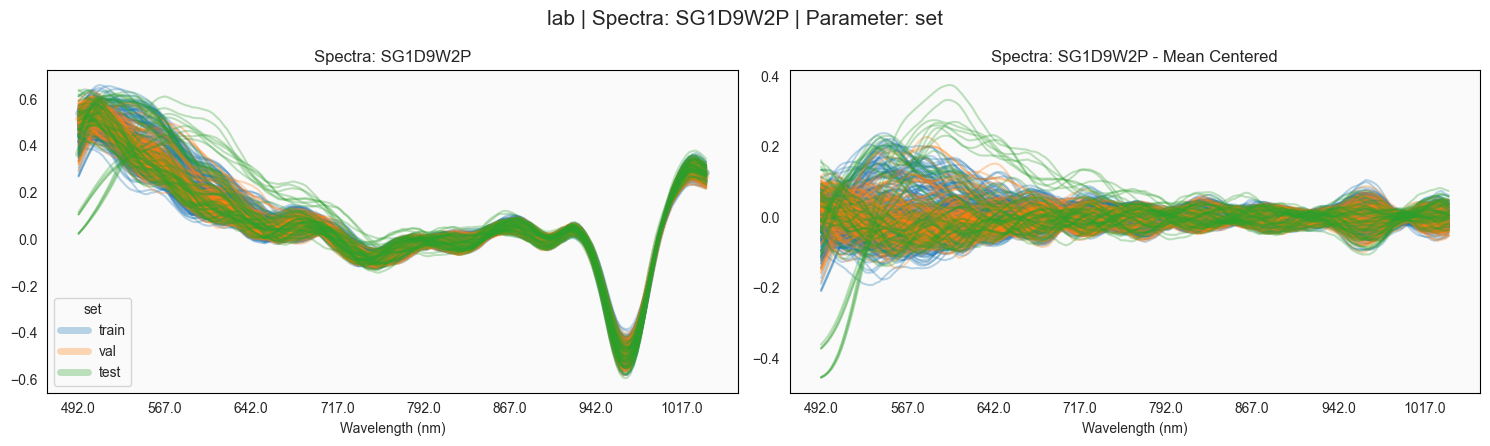

In [29]:
for selection in selections:
    print(f'\nProcessing {selection} dataset')
    output_dir = viz_output_dir/f"{selection}/{PREPROCESSING}"
    output_dir.mkdir(exist_ok=True, parents=True)

    SAMPLE_TYPE = f'{selection}'

    selected_df = selections[selection]['cleaned_input']
    selected_labels = selections[selection]['cleaned_label']
    param_label_map = selections[selection]['param_label_map']
    
    print(selected_df.shape, selected_labels.shape)

    msc = SavitzkyGolay(deriv=1, window=9, polyorder=2)
    msc_df = pd.DataFrame(msc.fit_transform(selected_df), 
                        columns=selected_df.columns[4:-4], index=selected_df.index)
    plot_df = msc_df.copy()

    selections[selection]['plot_df'] = plot_df

    for param, label_type in param_label_map.items():
        # check if png exists
        if (output_dir / f"{selection}_spectra_{param}.png").exists():
            print(f"Skipping {selection} {param}")
            continue

        if param == 'set':
            desired_order = ['train', 'val', 'test']
            selected_labels[param] = pd.Categorical(selected_labels[param], categories=desired_order, ordered=True)
        
        print(f'Generating figure for {param}')
        plot_spectra(plot_df, labels=selected_labels[[param]],
                    label_type=label_type,
                    spec_prep=PREPROCESSING,
                    sample_type=SAMPLE_TYPE,
                    # cmap=cmap
                    )
        
        # plt.savefig(output_dir / f"{selection}_spectra_{param}.png", bbox_inches='tight')
        plt.show()
        plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


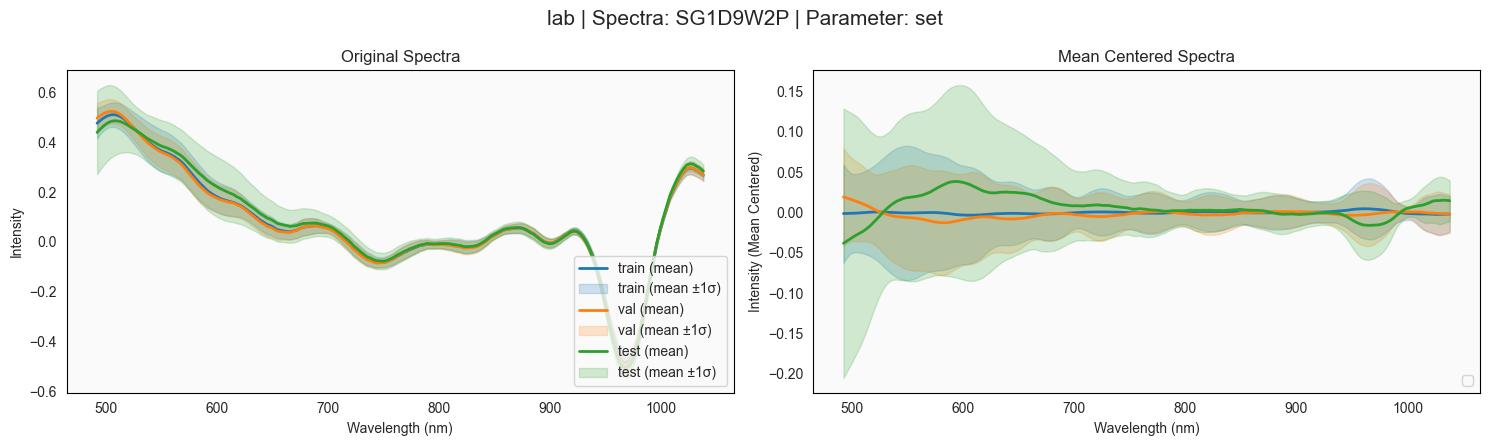

In [30]:
plot_spectra_summary(plot_df, 
                    selected_labels[[param]],
                    spec_prep=PREPROCESSING,
                    sample_type=SAMPLE_TYPE,
                    label_order=['train', 'val','test'], 
                    mean_center=True)

plt.savefig(output_dir / f"{selection}_statsummary_{param}.png", bbox_inches='tight')

In [ ]:
N_COMP = 0.95
RANDOM_STATE = 42

for selection in selections:

    output_dir = viz_output_dir/f"{selection}/{PREPROCESSING}"
    output_dir.mkdir(exist_ok=True, parents=True)
    
    SAMPLE_TYPE = f'{selection}'

    plot_df = selections[selection]['plot_df']

    fitted_pc, pc_labels = fit_pca(plot_df, N_COMP, RANDOM_STATE)

    selections[selection]['fitted_pc'] = fitted_pc
    selections[selection]['pc_labels'] = pc_labels

    fig2, ax2 = plot_loadings(plot_df, fitted_pc, pc_labels, 
                            spec_prep=PREPROCESSING, 
                            sample_type=SAMPLE_TYPE)
    
    plt.savefig(output_dir / f"{selection}_pca_loadings.png", bbox_inches='tight')
    plt.show()
    plt.close()

    fig1, ax1 = plot_scree(fitted_pc,
                        spec_prep=PREPROCESSING, 
                        sample_type=SAMPLE_TYPE)
    print(f"""Total Explained Variance: {fitted_pc.explained_variance_ratio_.sum()*100:.3f}% 
    Number of Components: {len(fitted_pc.explained_variance_ratio_)}""")

    plt.savefig(output_dir / f"{selection}_scree_plot.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
for selection in selections:
    SAMPLE_TYPE = f'{selection}'
    print(f'\nProcessing {selection} dataset')
    output_dir = viz_output_dir/f"{selection}/{PREPROCESSING}"
    output_dir.mkdir(exist_ok=True, parents=True)
    
    selected_df = selections[selection]['cleaned_input']
    selected_labels = selections[selection]['cleaned_label']
    param_label_map = selections[selection]['param_label_map']
    plot_df = selections[selection]['plot_df']
    fitted_pc = selections[selection]['fitted_pc']
    pc_labels = selections[selection]['pc_labels']

    print(plot_df.shape, selected_labels.shape)

    for param in param_label_map.keys():
        # check if png exists
        if (output_dir / f"{selection}_pca_{param}.png").exists():
            print(f"Skipping {selection} {param}")
            continue

        print(f'Generating figure for {param}')
        pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=selected_labels[[param]])
        sns.pairplot(data=pc_df.reset_index().drop('lot_id', axis=1), hue=param)
        plt.suptitle(f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING} | Parameter: {param}', y=1.02, size=15)

        plt.savefig(output_dir / f"{selection}_pca_{param}.png", bbox_inches='tight')
        # plt.show()
        plt.close()

In [ ]:
# fig = make_subplots(rows=3, cols= 2, 
#                     subplot_titles=['F Test Spectra', 'F Test PCA', 
#                                     'Mutual Info Spectra', 'Mutual Info PCA',
#                                     'Chi2 Spectra', 'Chi2 PCA'],
#                     specs=[[{'secondary_y': True}, {'secondary_y': True}],
#                            [{'secondary_y': False}, {'secondary_y': False}],
#                            [{'secondary_y': True}, {'secondary_y': True}]],
#                     horizontal_spacing=0.15,
#                     vertical_spacing=0.1)

# title = f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING}'
# colors = px.colors.qualitative.Plotly
# pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=label_df)
# n_comp = fitted_pc.n_components_

# for i, param in enumerate(param_label_map.keys()):
#     try:
#         f_reg_spec = f_classif(plot_df, label_df[param].values.ravel())
#         f_reg_pca = f_classif(pc_df.iloc[:, :n_comp], pc_df[param].values.ravel())
#         mms = MinMaxScaler()
#         scaled_spec = mms.fit_transform(plot_df)
#         scaled_pca = mms.fit_transform(pc_df.iloc[:, :n_comp])
#         mi_spec = mutual_info_classif(scaled_spec, label_df[param].values.ravel())
#         mi_pca = mutual_info_classif(scaled_pca, pc_df[param].values.ravel())
#         chi2_spec = chi2(scaled_spec, label_df[param].values.ravel())
#         chi2_pca = chi2(scaled_pca, pc_df[param].values.ravel())
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=mi_spec, marker_color=colors[i], name=param,
#                        opacity=0.8, showlegend=False),
#                        secondary_y=False,row=2, col=1)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=mi_pca, name=param, marker_color=colors[i],
#                        showlegend=False, opacity=0.8),
#                     secondary_y=False, row=2, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=2)
        
#     except:
#         pass

# # Add figure title
# fig.update_layout(title_text=title, height=1400, width=1400)
# fig.update_xaxes(title_text="Wavelengths (nm)", col=1)
# fig.update_xaxes(title_text="No. of PCs", col=2)

# # Set y-axes titles
# fig.update_yaxes(title_text="F value", secondary_y=False, row=1)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=1)
# fig.update_yaxes(title_text="Mutual Information", secondary_y=False, row=2)
# fig.update_yaxes(title_text="Chi2", secondary_y=False, row=3)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=3)

# fig.show()

# SG2D9W2P

In [ ]:
# # CONFIGS
# PREPROCESSING = 'SG2D9W2P'
# spectra_meta = {}

In [ ]:
# for selection in selections:
#     SAMPLE_TYPE = f'{selection}'
    
#     for split in data_split:
#         key = f'{selection}_{split}'
#         if key in cleaned_spectra:
#             if split == 'spectra':
#                 selected_df = cleaned_spectra[key]
#             elif split == 'label':
#                 selected_labels = cleaned_spectra[key]
#             print(f'Assigned {key} to {split}_df')

#     msc = SavitzkyGolay(deriv=2, window=9, polyorder=2)
#     msc_df = pd.DataFrame(msc.fit_transform(selected_df), 
#                         columns=selected_df.columns[4:-4], index=selected_df.index)
#     plot_df = msc_df.copy()

#     spectra_meta = {
#         **spectra_meta,
#         f'{selection}_plot_df' : plot_df
#     }

#     for param, label_type in param_label_map.items():
#         plot_spectra(plot_df, labels=selected_labels[[param]],
#                     label_type=label_type,
#                     spec_prep=PREPROCESSING,
#                     sample_type=SAMPLE_TYPE,
#                     cmap=cmap)

In [ ]:
# N_COMP = 0.95
# RANDOM_STATE = 42

# for selection in selections:
#     SAMPLE_TYPE = f'{selection}'

#     plot_df = spectra_meta[f'{selection}_plot_df']

#     fitted_pc, pc_labels = fit_pca(plot_df, N_COMP, RANDOM_STATE)

#     spectra_meta = {
#         **spectra_meta,
#         f'{selection}_fitted_pc' : fitted_pc,
#         f'{selection}_pc_labels' : pc_labels,
#         }

#     fig2, ax2 = plot_loadings(plot_df, fitted_pc, pc_labels, 
#                             spec_prep=PREPROCESSING, 
#                             sample_type=SAMPLE_TYPE)
#     fig1, ax1 = plot_scree(fitted_pc,
#                         spec_prep=PREPROCESSING, 
#                         sample_type=SAMPLE_TYPE)
#     print(f"""Total Explained Variance: {fitted_pc.explained_variance_ratio_.sum()*100:.3f}% 
#     Number of Components: {len(fitted_pc.explained_variance_ratio_)}""")

In [ ]:
# for selection in selections:
#     SAMPLE_TYPE = f'{selection}'

#     for split in data_split:
#         key = f'{selection}_{split}'
#         if key in cleaned_spectra:
#             if split == 'spectra':
#                 selected_df = cleaned_spectra[key]
#             elif split == 'label':
#                 selected_labels = cleaned_spectra[key]
#             print(f'Assigned {key} to {split}_df')
    
#     plot_df = spectra_meta[f'{selection}_plot_df']
#     fitted_pc = spectra_meta[f'{selection}_fitted_pc']
#     pc_labels = spectra_meta[f'{selection}_pc_labels']

#     for param in param_label_map.keys():
#         pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=selected_labels[[param]])
#         sns.pairplot(data=pc_df.reset_index().drop('lot_id', axis=1), hue=param)
#         plt.suptitle(f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING} | Parameter: {param}', y=1.02, size=15)

In [ ]:
# fig = make_subplots(rows=3, cols= 2, 
#                     subplot_titles=['F Test Spectra', 'F Test PCA', 
#                                     'Mutual Info Spectra', 'Mutual Info PCA',
#                                     'Chi2 Spectra', 'Chi2 PCA'],
#                     specs=[[{'secondary_y': True}, {'secondary_y': True}],
#                            [{'secondary_y': False}, {'secondary_y': False}],
#                            [{'secondary_y': True}, {'secondary_y': True}]],
#                     horizontal_spacing=0.15,
#                     vertical_spacing=0.1)

# title = f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING}'
# colors = px.colors.qualitative.Plotly
# pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=label_df)
# n_comp = fitted_pc.n_components_

# for i, param in enumerate(param_label_map.keys()):
#     try:
#         f_reg_spec = f_classif(plot_df, label_df[param].values.ravel())
#         f_reg_pca = f_classif(pc_df.iloc[:, :n_comp], pc_df[param].values.ravel())
#         mms = MinMaxScaler()
#         scaled_spec = mms.fit_transform(plot_df)
#         scaled_pca = mms.fit_transform(pc_df.iloc[:, :n_comp])
#         mi_spec = mutual_info_classif(scaled_spec, label_df[param].values.ravel())
#         mi_pca = mutual_info_classif(scaled_pca, pc_df[param].values.ravel())
#         chi2_spec = chi2(scaled_spec, label_df[param].values.ravel())
#         chi2_pca = chi2(scaled_pca, pc_df[param].values.ravel())
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=f_reg_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=1, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=f_reg_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=1, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=mi_spec, marker_color=colors[i], name=param,
#                        opacity=0.8, showlegend=False),
#                        secondary_y=False,row=2, col=1)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=mi_pca, name=param, marker_color=colors[i],
#                        showlegend=False, opacity=0.8),
#                     secondary_y=False, row=2, col=2)
        
#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=1)

#         fig.add_trace(
#             go.Scatter(x=plot_df.columns, y=chi2_spec[1], name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=1)
        
#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[0], marker_color=colors[i], name=param,
#                        opacity=0.5, showlegend=False),
#                        secondary_y=False,row=3, col=2)

#         fig.add_trace(
#             go.Scatter(x=pc_df.columns[:n_comp], y=chi2_pca[1], showlegend=False,
#                        name=param, marker_color=colors[i]),
#                     secondary_y=True, row=3, col=2)
        
#     except:
#         pass

# # Add figure title
# fig.update_layout(title_text=title, height=1400, width=1400)
# fig.update_xaxes(title_text="Wavelengths (nm)", col=1)
# fig.update_xaxes(title_text="No. of PCs", col=2)

# # Set y-axes titles
# fig.update_yaxes(title_text="F value", secondary_y=False, row=1)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=1)
# fig.update_yaxes(title_text="Mutual Information", secondary_y=False, row=2)
# fig.update_yaxes(title_text="Chi2", secondary_y=False, row=3)
# fig.update_yaxes(title_text="p value", secondary_y=True, row=3)

# fig.show()